In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['HIP_VISIBLE_DEVICES'] = '0'

In [2]:
seed = 123
torch.manual_seed(seed)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_set = MNIST(root="../datasets", train=True, download=True, transform=transforms.ToTensor())
test_set = MNIST(root="../datasets", train=False, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:28<00:00, 342190.63it/s]


Extracting ../datasets\MNIST\raw\train-images-idx3-ubyte.gz to ../datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 96103.44it/s]


Extracting ../datasets\MNIST\raw\train-labels-idx1-ubyte.gz to ../datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:25<00:00, 64700.41it/s] 


Extracting ../datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to ../datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1255471.78it/s]

Extracting ../datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../datasets\MNIST\raw



In [4]:
train_set, test_set

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ../datasets
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ../datasets
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [5]:
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super(AutoEncoder, self).__init__()

        self.encoder_layer1 = nn.Linear(28 * 28, 128, bias=False)
        self.encoder_bn1 = nn.BatchNorm1d(128)
        self.encoder_layer2 = nn.Linear(128, 64, bias=False)
        self.encoder_bn2 = nn.BatchNorm1d(64)
        self.encoder_layer3 = nn.Linear(64, 32, bias=False)
        self.encoder_bn3 = nn.BatchNorm1d(32)

        self.decoder_layer1 = nn.Linear(32, 64, bias=False)
        self.decoder_bn1 = nn.BatchNorm1d(64)
        self.decoder_layer2 = nn.Linear(64, 128, bias=False)
        self.decoder_bn2 = nn.BatchNorm1d(128)
        self.decoder_layer3 = nn.Linear(128, 28 * 28, bias=True)
        # self.decoder_bn3 = nn.BatchNorm1d(28 * 28)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    
    def forward(self, x):

        # encoder forward pass
        x = self.relu(self.encoder_bn1(self.encoder_layer1(x)))
        x = self.relu(self.encoder_bn2(self.encoder_layer2(x)))
        x = self.relu(self.encoder_bn3(self.encoder_layer3(x)))

        latent = x.detach().clone()

        # decoder forward pass
        x = self.relu(self.decoder_bn1(self.decoder_layer1(x)))
        x = self.relu(self.decoder_bn2(self.decoder_layer2(x)))
        x = self.sigmoid(self.decoder_layer3(x))

        return x, latent

In [7]:
model = AutoEncoder().to(DEVICE)

In [7]:
NUM_EPOCH = 20
LEARNING_RATE = 1e-4

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [33]:
min_loss = float('inf')

for epoch in range(NUM_EPOCH):

    mean_loss = []

    for img, _ in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        img = img.view(-1, 1 * 28 * 28).to(DEVICE)
        out = model(img + torch.randn_like(img) * 0.1)

        loss = criterion(out, img)

        mean_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_loss = sum(mean_loss) / len(mean_loss)

    print(f'Mean loss: {mean_loss}')

    if mean_loss < min_loss:
        torch.save(model.state_dict(), "./best_model.pth")
        min_loss = mean_loss

Epoch 1: 100%|██████████| 938/938 [00:12<00:00, 73.38it/s]


Mean loss: 0.01270469527906065


Epoch 2: 100%|██████████| 938/938 [00:12<00:00, 72.94it/s]


Mean loss: 0.012515698099878233


Epoch 3: 100%|██████████| 938/938 [00:12<00:00, 72.18it/s]


Mean loss: 0.012418527592982311


Epoch 4: 100%|██████████| 938/938 [00:13<00:00, 69.52it/s]


Mean loss: 0.012269245845867372


Epoch 5: 100%|██████████| 938/938 [00:12<00:00, 73.32it/s]


Mean loss: 0.012144670250819627


Epoch 6: 100%|██████████| 938/938 [00:12<00:00, 72.64it/s]


Mean loss: 0.012051533303980125


Epoch 7: 100%|██████████| 938/938 [00:13<00:00, 71.78it/s]


Mean loss: 0.01193415003020499


Epoch 8: 100%|██████████| 938/938 [00:12<00:00, 73.94it/s]


Mean loss: 0.011855164755270806


Epoch 9: 100%|██████████| 938/938 [00:13<00:00, 70.59it/s]


Mean loss: 0.01174381003379504


Epoch 10: 100%|██████████| 938/938 [00:12<00:00, 73.75it/s]


Mean loss: 0.011675391158561654


Epoch 11: 100%|██████████| 938/938 [00:12<00:00, 74.19it/s]


Mean loss: 0.011588714544230433


Epoch 12: 100%|██████████| 938/938 [00:12<00:00, 72.19it/s]


Mean loss: 0.01147067799334174


Epoch 13: 100%|██████████| 938/938 [00:12<00:00, 73.24it/s]


Mean loss: 0.011415647057844187


Epoch 14: 100%|██████████| 938/938 [00:12<00:00, 72.91it/s]


Mean loss: 0.011334324227784997


Epoch 15: 100%|██████████| 938/938 [00:13<00:00, 71.95it/s]


Mean loss: 0.011263432306870977


Epoch 16: 100%|██████████| 938/938 [00:13<00:00, 71.42it/s]


Mean loss: 0.011201163550326501


Epoch 17: 100%|██████████| 938/938 [00:12<00:00, 73.09it/s]


Mean loss: 0.011155578835027368


Epoch 18: 100%|██████████| 938/938 [00:12<00:00, 74.78it/s]


Mean loss: 0.011075423770288287


Epoch 19: 100%|██████████| 938/938 [00:12<00:00, 74.93it/s]


Mean loss: 0.011030674313328095


Epoch 20: 100%|██████████| 938/938 [00:12<00:00, 74.08it/s]

Mean loss: 0.010984991131020761


In [8]:
best_model = AutoEncoder()
best_model.load_state_dict(torch.load("./best_model.pth", weights_only=True))
best_model = best_model.to(DEVICE)

In [11]:
best_model.eval()

with torch.no_grad():
    i = 1
    for true_imgs, _ in tqdm(test_loader):
        true_imgs = true_imgs.view(-1, 1 * 28 * 28).to(DEVICE)
        true_imgs = true_imgs + torch.randn_like(true_imgs) * 0.15  
        preds, _ = best_model(true_imgs)
        preds = preds.view(-1, 28, 28).cpu()

        for pred, true_img in zip(preds, true_imgs):
            if i % 100 == 0:
                save_image(pred, f'./generated_images/{i}_predicted.png')
                save_image(true_img.view(1, 28, 28).cpu(), f'./generated_images/{i}_original.png')

            i += 1

100%|██████████| 157/157 [00:01<00:00, 89.22it/s]


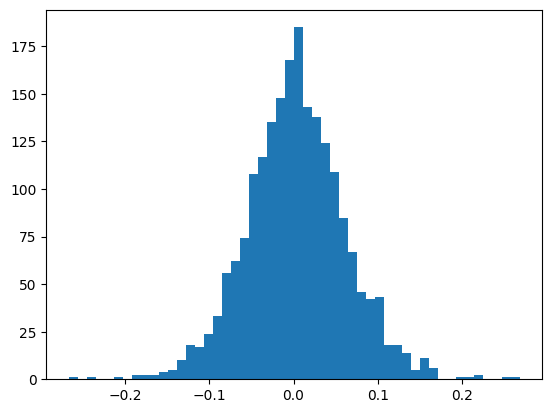

(tensor(0.0035), tensor(0.0587))

In [12]:
latent_space_weights = best_model.encoder_layer3.weight.detach().flatten()
plt.hist(latent_space_weights.tolist(), bins=50)
plt.show()
torch.mean(latent_space_weights), torch.std(latent_space_weights)

In [13]:
latent_vectors = []
labels = []

for images, targets in test_loader:
    images = images.view(-1, 1 * 28 * 28)  # Flatten the images
    images += torch.randn_like(images) * 0.1
    _, latent = model(images)           # Get latent vectors
    latent_vectors.append(latent.cpu())
    labels.append(targets)

latent_vectors = torch.cat(latent_vectors)
labels = torch.cat(labels)

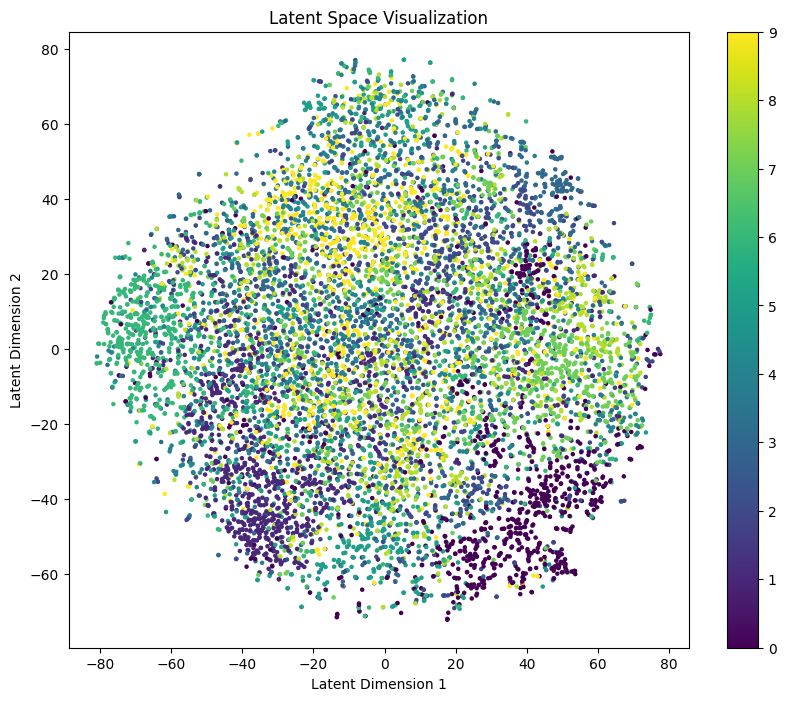

In [14]:
latent_2d = TSNE(n_components=2).fit_transform(latent_vectors)
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis', s=5)
plt.colorbar()
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()